In [5]:
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

Training on cpu using PyTorch 1.13.0 and Flower 1.1.0


### Prendo le dipendenze
sources: https://github.com/adap/flower/blob/main/doc/source/tutorial/Flower-1-Intro-to-FL-PyTorch.ipynb

# Set up data

In [6]:
# CNN in FL, dataset CIFAR10, images classification
#We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original CIFAR-10 dataset into multiple partitions.
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# client = organization
NUM_CLIENTS = 10
BATCH_SIZE = 32

def load_datasets():
    # Download and transform CIFAR-10 (train and test) - We use transforms to perform some manipulation of the data and make it suitable for training.
    #All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic.
    transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()


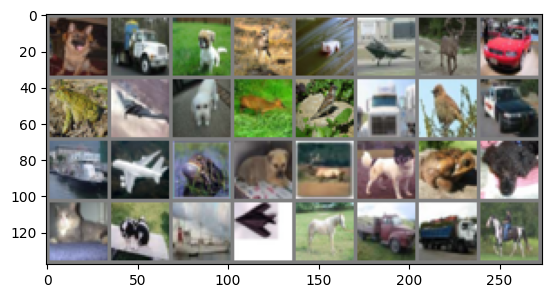

  dog truck   dog  deer  frog plane  deer   car  frog plane   dog  deer  bird truck  bird   car  ship plane  frog   dog  deer   dog  frog   dog   cat   dog  ship plane horse truck truck horse


In [8]:
images, labels = iter(trainloaders[0]).__next__()
#The output above shows a random batch of images from the first trainloader in our list of ten trainloaders
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(32)))

 # Step 1: Centralized Training with PyTorch

## Defining the model - a basic CNN


In [9]:

class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        #Applies a 2D max pooling over an input signal composed of several input planes.
        # [In una matrice n x n prende il valore massimo - riduce dimensioni e varianza - 2,2  in which case, the first int is used for the height dimension, and the second int for the width dimension]
        self.pool = nn.MaxPool2d(2, 2)
        # 2d convulation - (in_channels: int, out_channels: int, kernel_size: Union[int, tuple[int, int]])
        self.conv2 = nn.Conv2d(6, 16, 5)
        #trasformazioni lineari [ fc2 esempio: input features=120 , output_feature=84]
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:

def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

## Training the model - only one organization

In [11]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")


Epoch 1: validation loss 0.06503377389907837, accuracy 0.272
Epoch 2: validation loss 0.05619271326065063, accuracy 0.358
Epoch 3: validation loss 0.05477488398551941, accuracy 0.376
Epoch 4: validation loss 0.05093993473052978, accuracy 0.412
Epoch 5: validation loss 0.04985689544677734, accuracy 0.428
Final test set performance:
	loss 0.047875715458393094
	accuracy 0.4341


## Federated Learning with Flower

Prepare function for updating of parameters.


In [12]:

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

## Implementing a Flower client
With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of flwr.client.Client or flwr.client.NumPyClient. We use NumPyClient in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of flwr.client.NumPyClient and implement the three methods get_parameters, fit, and evaluate:

- get_parameters: Return the current local model parameters
- fit: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
- evaluate: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

In [13]:

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

### Using the Virtual Client Engine

we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10
instances of FlowerClient im memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.


In addition to the regular capabilities where server and clients run on multiple machines, Flower therefore provides special simulation capabilities that create FlowerClient instances only when they are actually necessary for training or evaluation.

To enable the Flower framework to create clients when necessary, we need to implement a function called **client_fn** that creates a FlowerClient instance on demand. Flower calls  **client_fn**  whenever it needs an instance of one particular client to
all fit or evaluate (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short cid. The cid can be used, for example, to load different local data partitions for different
clients

In [14]:

def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)


## Train on client

The function start_simulation accepts a number of arguments, amongst them the client_fn used to create FlowerClient instances, the number of clients to simulate (num_clients), the number of federated learning rounds (num_rounds), and the strategy.
The strategy encapsulates the federated learning approach/algorithm, for example, Federated Averaging (FedAvg).

In [15]:

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=10,  # Never sample less than 10 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=10,  # Wait until all 10 clients are available
)



When we call start_simulation, we tell Flower that there are
 10 clients (num_clients=10). Flower then goes ahead an asks the FedAvg strategy to select clients. FedAvg knows that it should select 100% of the available clients (fraction_fit=1.0), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

In [16]:
# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)


INFO flower 2022-12-07 15:00:57,121 | app.py:140 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2022-12-07 15:00:58,471	INFO worker.py:1518 -- Started a local Ray instance.
INFO flower 2022-12-07 15:00:59,773 | app.py:174 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'memory': 17334089728.0}
INFO flower 2022-12-07 15:00:59,774 | server.py:86 | Initializing global parameters
INFO flower 2022-12-07 15:00:59,774 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2022-12-07 15:01:01,930 | server.py:274 | Received initial parameters from one random client
INFO flower 2022-12-07 15:01:01,931 | server.py:88 | Evaluating initial parameters
INFO flower 2022-12-07 15:01:01,931 | server.py:101 | FL starting
DEBUG flower 2022-12-07 15:01:01,932 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-12-07 15:01:17,696 | serv

History (loss, distributed):
	round 1: 0.06337231631278992
	round 2: 0.05501003618240356
	round 3: 0.05160613174438476
	round 4: 0.049081042861938484
	round 5: 0.046655636501312256

create a simple weighted averaging function to aggregate the accuracy metric we return from evaluate


In [17]:

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

We now have a full system that performs federated training and federated evaluation. It uses the weighted_average function to aggregate custom evaluation metrics and calculates a single accuracy metric across all clients on the server side.

The other two categories of metrics (losses_centralized and metrics_centralized) are still empty because they only apply when centralized evaluation is being used. Part two of the Flower tutorial will cover centralized evaluation.

In [18]:

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)


INFO flower 2022-12-07 15:02:58,810 | app.py:140 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2022-12-07 15:03:03,326	INFO worker.py:1518 -- Started a local Ray instance.
INFO flower 2022-12-07 15:03:06,333 | app.py:174 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 16526838170.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-12-07 15:03:06,335 | server.py:86 | Initializing global parameters
INFO flower 2022-12-07 15:03:06,335 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2022-12-07 15:03:11,227 | server.py:274 | Received initial parameters from one random client
INFO flower 2022-12-07 15:03:11,228 | server.py:88 | Evaluating initial parameters
INFO flower 2022-12-07 15:03:11,228 | server.py:101 | FL starting
DEBUG flower 2022-12-07 15:03:11,229 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-12-07 15:03:27,485 | serv

History (loss, distributed):
	round 1: 0.062330683994293215
	round 2: 0.05460174074172973
	round 3: 0.05065264682769775
	round 4: 0.048122539854049684
	round 5: 0.04796218700408936
History (metrics, distributed):
{'accuracy': [(1, 0.29560000000000003), (2, 0.36239999999999994), (3, 0.4176), (4, 0.4448), (5, 0.446)]}